## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [15]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [3]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [9]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBBSSBSS'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
584
+------------------+-------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+--------------------+------------------+-----------+------------+------+--------------------+------+
|           coeff_1|            coeff_2|           coeff_3|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|               res_3|          res_mean|    station|   total_var|undefs|              vector|  year|
+------------------+-------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+--------------------+------------------+-----------+------------+------+--------------------+------+
|11205.420962331635| -2366.064654159652|2473.6314804565363|   2499.4|SBBSSBSS| 42.5333|-108.7667|       SNWD|0.11980034930927934|0.08619503239521785|0.040981702483828646|0.8788

In [10]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather
+-----------+--------+---------+---------+------------------+
|    station|latitude|longitude|elevation|           coeff_1|
+-----------+--------+---------+---------+------------------+
|USC00480443| 42.5333|-108.7667|   2499.4|11205.420962331635|
|USC00480443| 42.5333|-108.7667|   2499.4| 10404.48011160797|
|USC00485105| 41.8172|-110.5328|   2115.9| 3106.446956486766|
|USC00482995| 41.6878|-106.4136|   2214.4| 9895.650579691359|
+-----------+--------+---------+---------+------------------+
only showing top 4 rows



In [11]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

,station,latitude,longitude,elevation,count(station),avg(coeff_1)
28,US1WYCR0001,41.8991,-106.2002,2001.0,1,-302.577987
16,US1WYFM0021,42.7630,-108.7933,1855.6,1,-156.694089


In [29]:
pdf.sort_values('longitude')

,station,latitude,longitude,elevation,count(station),avg(coeff_1)
23,USC00487955,41.8667,-111.0000,1892.8,3,849.959311
30,USC00480027,42.7292,-110.9297,1903.5,24,2301.012149
39,USC00483582,41.8367,-110.7703,2066.5,18,1733.028815
58,USC00485105,41.8172,-110.5328,2115.9,21,1294.077497
11,USW00024118,41.4000,-110.4167,2140.9,7,846.795408
7,USC00485252,42.2644,-110.1950,2011.1,13,215.773793
8,USW00024164,42.5844,-110.1075,2124.5,19,557.280695
2,USC00483396,41.8183,-110.0564,1975.1,5,517.817072
32,USC00480951,42.7158,-109.6903,2115.3,23,716.269782
31,USC00484065,41.5167,-109.4703,1869.3,2,29.694272


In [12]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#0044ff'

## Map

In [20]:
min_lat,max_lat,min_long,max_long = box = (pdf.latitude.min(), pdf.latitude.max(), pdf.longitude.min(), pdf.longitude.max())

In [31]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4, tag=row.station, 
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

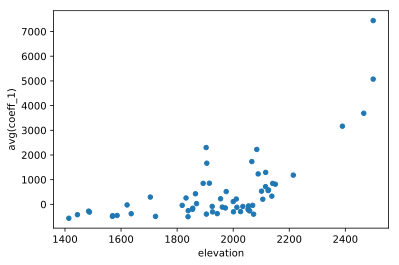

In [11]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');

In [12]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

['spark big  data analysis', 'spring', 'spark  basics']